In [1]:
!pip install mlflow pyvi minio -q
import mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 59.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 96.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 87.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 700.2/700.2 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.1 MB/s eta 0:00:00


In [2]:
mlflow.set_tracking_uri("http://36.50.135.226:7893/")

# from mlflow.tracking import MlflowClient

# client = MlflowClient()
# client.restore_experiment(experiment_id="2")

mlflow.set_experiment(experiment_id="12")

<Experiment: artifact_location='s3://mlflow/8', creation_time=1746431673147, experiment_id='12', last_update_time=1746431673147, lifecycle_stage='active', name='Eval_15Epoch_TrainFullData_TPC3k7_BartPho-ViT-GPT2_LoRALayerFT_AllMetrics', tags={}>

In [3]:
import os

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "http://36.50.135.226:9000"
os.environ["AWS_ACCESS_KEY_ID"] = "minio"
os.environ["AWS_SECRET_ACCESS_KEY"] = "minio123"

In [4]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import json
import transformers
from transformers import VisionEncoderDecoderModel, ViTImageProcessor
import torch
from PIL import Image
import torch.nn as nn
import cv2
import torchvision
from tqdm.notebook import tqdm
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import ViTForImageClassification, ViTImageProcessor
from collections import OrderedDict
from transformers import GPT2Config, GPT2LMHeadModel
import mlflow
import mlflow.pytorch
import re
from pyvi import ViTokenizer
from torch.optim import AdamW

2025-05-07 15:40:47.250217: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746632447.453221      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746632447.514098      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Adjust component

In [5]:
"""
2. Load feature extractor
"""
feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

def load_image(image_url):
    try:
        response = requests.get(image_url, timeout=10)
        if response.status_code != 200:
            print(f"Error: Failed to fetch image, status code {response.status_code}")
            return None

        image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
        image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

        if image is None:
            print("Error: OpenCV could not decode the image.")
            return None

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image_rgb
    except requests.exceptions.RequestException as e:
        print(f"Error: Request failed - {e}")
        return None


def load_image_evaluate(local_path, dataset_base_path="/kaggle/input/traffic-pictures-captioning/"):
    """
    Load ảnh từ local_path trong dataset trên Kaggle.
    
    Parameters:
    - local_path (str): Đường dẫn tương đối của ảnh (từ cột 'url' trong DataFrame)
    - dataset_base_path (str): Đường dẫn gốc đến dataset
    
    Returns:
    - image_rgb (numpy.ndarray): Ảnh ở định dạng RGB, hoặc None nếu lỗi
    """
    try:
        # Chuẩn hóa đường dẫn ảnh
        local_path = local_path.lstrip('./')  # Loại bỏ './' nếu có
        full_image_path = os.path.join(dataset_base_path, local_path)
        
        # Đọc ảnh bằng OpenCV
        image = cv2.imread(full_image_path)
        if image is None:
            print(f"Lỗi: Không thể đọc ảnh từ {full_image_path}")
            return None
        
        # Chuyển từ BGR sang RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image_rgb
    
    except Exception as e:
        print(f"Lỗi khi xử lý ảnh {full_image_path}: {e}")
        return None

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [6]:
"""
3. Load Tokenizer
"""
from transformers import AutoTokenizer

# Load tokenizer của BartPho
# tokenizer = AutoTokenizer.from_pretrained("vinai/bartpho-syllable")
tokenizer = AutoTokenizer.from_pretrained("vinai/bartpho-word")

# Kiểm tra vocab size
vocab_size = tokenizer.vocab_size
print(f"VOCAB SIZE: {vocab_size}")

# In ra các special tokens
print("Special Tokens:", tokenizer.special_tokens_map)

config.json:   0%|          | 0.00/897 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

VOCAB SIZE: 64000
Special Tokens: {'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}


# 1. Generate Model

In [7]:
from PIL import Image

# Đường dẫn thư mục chứa các tệp mô hình
model_path = '/kaggle/input/phovit-gptcap/pytorch/default/15'

# Tải mô hình VisionEncoderDecoder
model = VisionEncoderDecoderModel.from_pretrained(model_path, ignore_mismatched_sizes=True)

# Hàm để dự đoán caption cho ảnh
def predict_internet_caption(model, image_path, evaluate=False):
    if evaluate == False:
        img = load_image(image_path)
    else:
        img = load_image_evaluate(image_path)

    if img is None:
        return None
    pixel_values =  feature_extractor(img, return_tensors="pt")["pixel_values"]
    output_ids = model.generate(
        pixel_values,
        max_length=60,
        min_length=20,
        num_beams=4,  # Tối ưu tốc độ
        do_sample=True,
        temperature=0.8,  # Giảm nhiệt độ
        top_k=20,
        top_p=0.9,  # Mở rộng lựa chọn từ
        no_repeat_ngram_size=3,  # Ngăn lặp cụm 5 từ
        repetition_penalty=2.0,  # Phạt lặp mạnh hơn
        early_stopping=True,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id,
        decoder_start_token_id=tokenizer.bos_token_id
    )
    print(output_ids[0])
    caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    caption = caption.replace("_", " ").strip()  # Loại bỏ dấu gạch dưới
    print(caption)
    return caption

In [14]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from io import BytesIO
from PIL import Image
import numpy as np

def sub_fig_to_image(fig):
    buf = BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    img = Image.open(buf)
    return np.array(img)
    
def display_images_in_4_frames_only_big_borders(model, image_urls):
    assert len(image_urls) == 12, "Cần đúng 12 ảnh để chia đều thành 4 frame (3 ảnh mỗi frame)"

    num_frames = 4
    images_per_frame = 3

    fig, frame_axes = plt.subplots(2, 2, figsize=(14, 12))  # Tăng khung chính

    for idx in range(num_frames):
        start = idx * images_per_frame
        end = start + images_per_frame
        sub_image_urls = image_urls[start:end]

        # 👉 Tăng chiều cao của sub_fig cho caption hiển thị thoải mái
        sub_fig, axes = plt.subplots(images_per_frame, 2, figsize=(8, 6))  # chiều cao tăng

        for i, image_url in enumerate(sub_image_urls):
            try:
                image_rgb = load_image(image_url)
                caption = predict_internet_caption(model, image_url)

                axes[i][0].imshow(image_rgb)
                axes[i][0].axis('off')

                # 👉 Cập nhật cách hiển thị caption: căn trái + wrap + padding
                axes[i][1].text(0, 1, caption,
                                fontsize=14,
                                ha='left',
                                va='top',
                                wrap=True,
                                transform=axes[i][1].transAxes)
                axes[i][1].axis('off')

            except Exception as e:
                print(f"Lỗi ở frame {idx}, ảnh {i}: {e}")
                axes[i][0].axis('off')
                axes[i][1].axis('off')

        sub_fig.tight_layout()
        img = sub_fig_to_image(sub_fig)
        axes_fig = frame_axes[idx // 2][idx % 2]
        axes_fig.imshow(img)
        axes_fig.axis('off')

        # Viền đậm
        rect = Rectangle((0, 0), 1, 1, transform=axes_fig.transAxes,
                         linewidth=3, edgecolor='black', facecolor='none')
        axes_fig.add_patch(rect)

        plt.close(sub_fig)

    fig.tight_layout()
    fig.savefig("four_frames_with_only_big_borders_fixed.png", dpi=300, bbox_inches='tight')
    plt.show()


tensor([    0,   448, 17922,     4,    10,   630, 27224,   216,    71,     5,
         8994,  2208,    57,   215,   365,    13,    18,    57,   215,    25,
          145,   732,     5,   981,     6,   747,  2201,   405,    88,     5,
         2478,   402,    25,   145,    41,     5,     2])
giao thông thưa thớt , có cầu bộ hành phía trước . biển báo hầm đi bộ dành cho người đi bộ ở bên trái . xe máy và ô tô ngược chiều bạn . vỉa hè an toàn ở bên phải .
tensor([   0,  448,   10,   36,  981,    5, 5236,  963,  109,  365,   13,   18,
          57,  215,  339,  159,  147,    5,   10,   18,   52,   89,  109,    5,
        8994,    6, 1690, 2633,   25,  216,  732,    5,  981, 1263,   81,  405,
           6, 2201,  405,   15,   88,    5,    2])
giao thông có nhiều xe máy . vạch kẻ đường dành cho người đi bộ nằm chính giữa . có người đang qua đường . biển báo và đèn tín hiệu ở phía trái . xe máy di chuyển cùng chiều và ngược chiều với bạn .
tensor([    0,   448, 17922,     4,   825,     8,   9

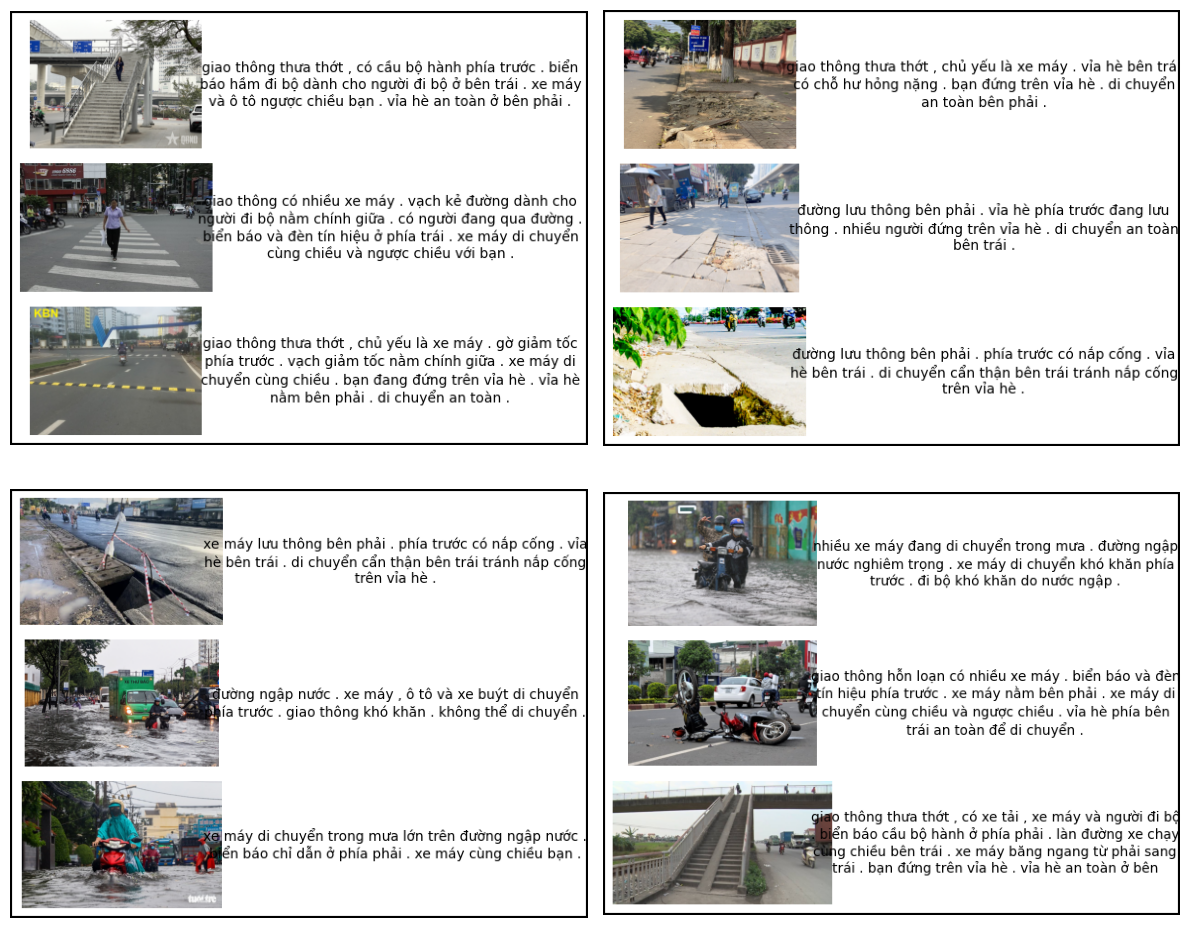

In [35]:
# Danh sách URL ảnh
image_urls = [
    "https://file3.qdnd.vn/data/images/0/2025/04/04/upload_2201/tr4%203.jpg?dpi=150&quality=100&w=870",
    "https://csgt-congan.hochiminhcity.gov.vn/wps/wcm/connect/3a334387-024e-4516-b496-3743b31916e1/1/470f34ab382de073b93c.jpg?MOD=AJPERES&CACHEID=3a334387-024e-4516-b496-3743b31916e1/1",
    "https://kbn.vn/wp-content/uploads/2018/08/Lap-dat-go-giam-toc-cao-su-kbS350-tai-lang-dai-hoc.jpg",
    "https://image.tienphong.vn/w1966/Uploaded/2025/krpexlpve-byrylex/2023_04_07/tp-7-2-2442.jpg",
    "https://baogiaothong.mediacdn.vn/upload/images/2022-4/article_img/2022-10-24/img-bgt-2021-dca4f60650ab97f5ceba-1666627257-width1280height920.jpg",
    "https://baokhanhhoa.vn/file/e7837c02857c8ca30185a8c39b582c03/dataimages/202005/original/images5404417_nap_cong_be_nguy_hiem.jpg",
    "https://cdn-images.vtv.vn/zoom/640_400/562122370168008704/2023/10/20/photo1697772338858-16977723393571200969407.jpg",
    "https://vcdn1-vnexpress.vnecdn.net/2023/06/20/Vung-Tau-ngap-5766-1658301310-7085-1687249572.jpg?w=460&h=0&q=100&dpr=2&fit=crop&s=TUw6eHlKu5p1-M-tpsf4pg",
    "https://cdn2.tuoitre.vn/thumb_w/480/471584752817336320/2024/10/8/base64-17283718455262095920496.jpeg",
    "https://shop2banh.vn/images/2022/07/20220713_7a5c7c723d44cdc6af056a742fdd06b3_1657683871.jpeg",
    "https://cdn.thuvienphapluat.vn/uploads/tintuc/2024/11/28/thong-ke-tai-nan-gt.jpg",
    "https://bcp.cdnchinhphu.vn/334894974524682240/2022/12/27/sau-tai-nan-khien-8-nguoi-chet-ra-soat-lai-bat-cap-tren-ql5-1672107677884260796888.jpg",
    # "https://media-cdn-v2.laodong.vn/Storage/NewsPortal/2021/3/26/893015/Ham-Di-Bo-7.jpg",
    # "https://image.plo.vn/w1000/Uploaded/2025/znorgt/2024_03_14/tp-thu-duc-5026.jpg.webp",
    # "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRzuybBrH_3SyTdH9d-e5vZ0Q1nRJlKgfl6AA&s",
]

# Hiển thị ảnh với bố cục dọc
display_images_in_4_frames_only_big_borders(model, image_urls)

# 2. Evaluate Model

## 2.1. Gen and Save

In [ ]:
def load_image_kaggle(local_path, dataset_base_path="/kaggle/input/traffic-pictures-captioning/"):
    """
    Load ảnh từ local_path trong dataset trên Kaggle.
    
    Parameters:
    - local_path (str): Đường dẫn tương đối của ảnh (từ cột 'url' trong DataFrame)
    - dataset_base_path (str): Đường dẫn gốc đến dataset
    
    Returns:
    - image_rgb (numpy.ndarray): Ảnh ở định dạng RGB, hoặc None nếu lỗi
    """
    try:
        # Chuẩn hóa đường dẫn ảnh
        local_path = local_path.lstrip('./')  # Loại bỏ './' nếu có
        full_image_path = os.path.join(dataset_base_path, local_path)
        
        # Đọc ảnh bằng OpenCV
        image = cv2.imread(full_image_path)
        if image is None:
            print(f"Lỗi: Không thể đọc ảnh từ {full_image_path}")
            return None
        
        # Chuyển từ BGR sang RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image_rgb
    
    except Exception as e:
        print(f"Lỗi khi xử lý ảnh {full_image_path}: {e}")
        return None

In [ ]:
def predict_and_save(test_df, output_file="caption_predict_12_03.json"):
    actual, predicted = {}, {}
    progress_bar = tqdm(test_df.iterrows(), total=len(test_df))

    for index, row in progress_bar:
        captions = [row['caption']]
        image_url = row['url']
        y_pred = predict_internet_caption(model, image_url, evaluate=True)

        if pd.isna(y_pred) or image_url.strip() == "":
            continue
            
        actual[index] = captions
        predicted[index] = [y_pred]
    
    # Cách 1: Tính từ tqdm.format_dict (nếu có)
    if hasattr(progress_bar, 'format_dict'):
        elapsed = progress_bar.format_dict['elapsed']
        n_iters = progress_bar.format_dict['n']
        avg_time_per_iter = elapsed / n_iters if n_iters > 0 else 0
    else:
        avg_time_per_iter = 0  # Fallback

    # Log vào MLflow
    print(f"⏱️ Avg time per iteration: {avg_time_per_iter:.2f}s")

    # Lưu kết quả
    results = {"actual": actual, "predicted": predicted}
    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(results, f, ensure_ascii=False, indent=4)
    
    print(f"✅ Results saved to: {output_file}")
    return avg_time_per_iter

## 2.2. Calculate Score

In [ ]:
# Đọc dữ liệu từ file JSON
def load_predict_result(output_file):
    with open(output_file, "r", encoding="utf-8") as f:
        loaded_results = json.load(f)

    actual = loaded_results["actual"]
    predicted = loaded_results["predicted"]
    print("Dữ liệu đã được tải lại thành công!")
    return actual, predicted

In [ ]:
!pip install rouge-score -q
!pip install pycocoevalcap -q

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer
from pycocoevalcap.cider.cider import Cider
# from nlgeval import compute_metrics

In [ ]:
# Tính BLEU scores
def bleu_score(actual, predicted):
    bleu_1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu_2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu_3 = corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0))
    bleu_4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    return bleu_1, bleu_2, bleu_3, bleu_4

In [ ]:
def compute_bleu(actual, predicted):
    min_key = int(min(actual.keys()))
    max_key = int(max(actual.keys()))
    
    # Khởi tạo danh sách để lưu BLEU score của tất cả các cặp
    bleu_1_scores = []
    bleu_2_scores = []
    bleu_3_scores = []
    bleu_4_scores = []
    
    for i in range(min_key, max_key + 1):
        actual_caption = actual.get(str(i), [])
        predicted_caption = predicted.get(str(i), [])
        
        if actual_caption and predicted_caption:
            bleu_1, bleu_2, bleu_3, bleu_4 = bleu_score(actual_caption, predicted_caption)
            # Lưu các điểm BLEU vào danh sách
            bleu_1_scores.append(bleu_1)
            bleu_2_scores.append(bleu_2)
            bleu_3_scores.append(bleu_3)
            bleu_4_scores.append(bleu_4)
    
    # Tính trung bình của các BLEU score
    average_bleu_1 = sum(bleu_1_scores) / len(bleu_1_scores)
    average_bleu_2 = sum(bleu_2_scores) / len(bleu_2_scores)
    average_bleu_3 = sum(bleu_3_scores) / len(bleu_3_scores)
    average_bleu_4 = sum(bleu_4_scores) / len(bleu_4_scores)

    return average_bleu_1, average_bleu_2, average_bleu_3, average_bleu_4


In [ ]:
from rouge_score import rouge_scorer

def compute_rouge(actual, predicted):
    # Tạo scorer tính các loại ROUGE hợp lệ
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # Lưu điểm cho từng loại ROUGE
    rouge1_scores, rouge2_scores, rougeL_scores = [], [], []

    # Tính điểm ROUGE cho từng cặp câu
    for index in actual.keys():
        actual_caption = " ".join(actual[index])  # Ghép các từ thành chuỗi
        predicted_caption = " ".join(predicted[index])  # Ghép các từ thành chuỗi

        # Tính điểm cho cặp hiện tại
        scores = scorer.score(actual_caption, predicted_caption)

        # Lưu điểm F1 cho từng loại
        rouge1_scores.append(scores['rouge1'].fmeasure)
        rouge2_scores.append(scores['rouge2'].fmeasure)
        rougeL_scores.append(scores['rougeL'].fmeasure)

    # Tính điểm trung bình cho từng loại ROUGE
    rouge1_avg = sum(rouge1_scores) / len(rouge1_scores)
    rouge2_avg = sum(rouge2_scores) / len(rouge2_scores)
    rougeL_avg = sum(rougeL_scores) / len(rougeL_scores)

    # Trả về ba giá trị ROUGE1, ROUGE2, ROUGEL
    return rouge1_avg, rouge2_avg, rougeL_avg


In [ ]:
# Hàm tính CIDEr (sử dụng pycocoevalcap)
def compute_cider(actual, predicted):
    cider_scorer = Cider()
    cider_score, _ = cider_scorer.compute_score(actual, predicted)
    return cider_score

In [ ]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from pycocoevalcap.cider.cider import Cider
import json

def load_predict_result(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data['actual'], data['predicted']

def compute_bleu(actual, predicted):
    # Prepare references and hypotheses for BLEU calculation
    references = []
    hypotheses = []
    
    for key in actual:
        # Get all reference captions for this image
        refs = [caption.strip().split() for caption in actual[key]]
        references.append(refs)
        
        # Get predicted caption for this image
        pred = predicted[key][0].strip().split() if predicted[key] else ['']
        hypotheses.append(pred)
    
    # Calculate BLEU scores with smoothing
    smoothie = SmoothingFunction().method4
    bleu_1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0), smoothing_function=smoothie)
    bleu_2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)
    bleu_3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)
    bleu_4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)
    
    return bleu_1, bleu_2, bleu_3, bleu_4

def compute_rouge(actual, predicted):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []
    
    for key in actual:
        # Get the first reference caption and predicted caption
        ref = actual[key][0].strip() if actual[key] else ''
        hyp = predicted[key][0].strip() if predicted[key] else ''
        
        scores = scorer.score(ref, hyp)
        rouge1_scores.append(scores['rouge1'].fmeasure)
        rouge2_scores.append(scores['rouge2'].fmeasure)
        rougeL_scores.append(scores['rougeL'].fmeasure)
    
    rouge1 = sum(rouge1_scores) / len(rouge1_scores)
    rouge2 = sum(rouge2_scores) / len(rouge2_scores)
    rougeL = sum(rougeL_scores) / len(rougeL_scores)
    
    return rouge1, rouge2, rougeL

def compute_cider(actual, predicted):
    cider_scorer = Cider()
    cider_score, _ = cider_scorer.compute_score(actual, predicted)
    return cider_score

def evaluate_model(caption_result_file_name='caption_predict_12_03.json'):
    try:
        # Load data with validation
        actual, predicted = load_predict_result(caption_result_file_name)
        if not actual or not predicted:
            raise ValueError("Empty actual or predicted captions")
            
        # Ensure keys match
        common_keys = set(actual.keys()) & set(predicted.keys())
        if not common_keys:
            raise ValueError("No matching keys between actual and predicted")
            
        # Filter to only common keys
        actual = {k: actual[k] for k in common_keys}
        predicted = {k: predicted[k] for k in common_keys}

        # Compute metrics with error handling
        metrics = {
            'bleu_1': 0.0,
            'bleu_2': 0.0,
            'bleu_3': 0.0,
            'bleu_4': 0.0,
            'rouge1': 0.0,
            'rouge2': 0.0, 
            'rougeL': 0.0,
            'cider': 0.0
        }

        # Compute BLEU scores
        try:
            bleu_1, bleu_2, bleu_3, bleu_4 = compute_bleu(actual, predicted)
            metrics.update({
                'bleu_1': bleu_1,
                'bleu_2': bleu_2,
                'bleu_3': bleu_3,
                'bleu_4': bleu_4
            })
        except Exception as e:
            print(f"BLEU calculation failed: {str(e)}")

        # Compute ROUGE scores
        try:
            rouge1, rouge2, rougeL = compute_rouge(actual, predicted)
            metrics.update({
                'rouge1': rouge1,
                'rouge2': rouge2,
                'rougeL': rougeL
            })
        except Exception as e:
            print(f"ROUGE calculation failed: {str(e)}")

        # Compute CIDEr score
        try:
            cider = compute_cider(actual, predicted)
            metrics['cider'] = cider
        except Exception as e:
            print(f"CIDEr calculation failed: {str(e)}")

        return metrics

    except Exception as e:
        print(f"Evaluation failed completely: {str(e)}")
        return {
            'bleu_1': 0.0,
            'bleu_2': 0.0,
            'bleu_3': 0.0,
            'bleu_4': 0.0,
            'rouge1': 0.0,
            'rouge2': 0.0,
            'rougeL': 0.0,
            'cider': 0.0
        }

In [ ]:
import mlflow

def log_evaluation_to_mlflow(model_name='BartPho_ViT_GPT2_LoRA_ICG_Final_Ep15', epoch_num='15', data_part='FULL', test_path='/kaggle/input/traffic-augment/test.json'):
    # Đặt tên cho phiên chạy MLflow
    run_name = f"Evaluate {model_name}"
    
    # Khởi động một phiên chạy MLflow
    with mlflow.start_run(run_name=run_name):   
        test_df = pd.read_json(test_path, orient='records')
        mlflow.log_metric('test_size', test_df.shape[0])
        mlflow.log_metric('epoch number', epoch_num)
        mlflow.log_param("data_part", data_part)
        # Gọi hàm generate
        caption_result_file_name = f"caption_predict_{model_name}.json"
        avg_time_per_iter = predict_and_save(test_df, output_file = caption_result_file_name)
        mlflow.log_metric('time per caption', avg_time_per_iter)

        # Gọi hàm evaluate để lấy kết quả đánh giá
        evaluation_scores = evaluate_model(caption_result_file_name)

        # Log các metric vào MLflow
        for metric_name, metric_value in evaluation_scores.items():
            mlflow.log_metric(metric_name, metric_value)
        
        # Log artifact (file kết quả) vào MLflow
        mlflow.log_artifact(caption_result_file_name)
        
        print(f"Đã log kết quả đánh giá và file từ '{caption_result_file_name}' vào MLflow.")

# Gọi hàm để log evaluation scores và file
log_evaluation_to_mlflow()